In [266]:
import json
import collections
import matplotlib.pyplot as plt
import numpy as np
import re
import csv
import pandas as pd
import nltk
from sklearn import preprocessing
import time
from datetime import datetime
from datetime import timedelta

from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LassoCV
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

from yellowbrick.regressor import ResidualsPlot
from yellowbrick.regressor import PredictionError

In [101]:
def release_base_dat():
    with open('data/processed_trumptwitterarchive.txt', 'r') as data_file:
        json_data = data_file.read()

    data = json.loads(json_data)

    times = [d['created_at'] for d in data]
    favorite_count = [d['favorite_count'] for d in data]
    retweet_count = [d['retweet_count'] for d in data]
    texts = [" ".join(d['processed_text']) for d in data]
    baseline_dat = pd.DataFrame({'created_time': pd.to_datetime(times),
#                                 'favorite_count': favorite_count, 
#                                'retweet_count': retweet_count, 
                                'texts': texts})  # not including favorite_count and retweet_count

    top_20_words = ["china", "billion", "products", "democrats", "great","dollars","tariffs","country", "mueller","border",\
                     "president", "congressman", "people", "korea", "party", "years", "farmers", "going", "trade", "never"]

    for word in top_20_words:
        baseline_dat[word] = baseline_dat['texts'].apply(lambda x: 1 if word in x else 0)

    display(baseline_dat.head())
    baseline_dat.to_csv('data/baseline_data_no_count.csv', index = False)

In [199]:
def merge_data(baseline_dir = 'data/baseline_data_no_count.csv', 
               senti_dir = 'data/sentimentAnalysis/senti.csv', 
               spx_dir = 'data/all_cleaned_SPX_data.csv', 
               m = 5):
    
    df1= pd.read_csv(baseline_dir)
    senti_data = pd.read_csv(senti_dir)
    df2 = senti_data[['time', 'positive_count', 'negative_count']]
    df = pd.merge(df1, df2, left_on = 'created_time', right_on='time').drop(['time'], axis=1)
    
    df['created_time'] = df['created_time'].apply(lambda x: pd.to_datetime(x))
    df['begin_time'] = df['created_time'].dt.floor('1min')
    df['end_time'] = df['begin_time'] + timedelta(minutes=m)
    
    data_econ = pd.read_csv('data/all_cleaned_SPX_data.csv')
    data_econ['datetime'] = pd.to_datetime(data_econ['datetime'], utc = True)
    df_econ = data_econ[['datetime', 'close']]
    
    df_merge1 = pd.merge(df, df_econ, left_on = 'begin_time', right_on='datetime').drop(['datetime'], axis=1)
    df_merge2 = pd.merge(df_merge1, df_econ, left_on = 'end_time', right_on='datetime').drop(['datetime'], axis=1)
    
    df_merge2['returns'] = (df_merge2['close_y']/df_merge2['close_x']-1)*10000 # returns in bps
    
    df_all = df_merge2.drop(['created_time','begin_time','end_time', 'close_x','close_y', 'texts'], axis=1)
    
    return df_all
    

In [200]:
def no_econ_data(baseline_dir = 'data/baseline_data_no_count.csv',
                 senti_dir = 'data/sentimentAnalysis/senti.csv'):
    '''
    Combine only baseline and sentiment analysis, WITHOUT response variable
    
    To do more EDA on features
    '''
    df1= pd.read_csv(baseline_dir)
    senti_data = pd.read_csv(senti_dir)
    df2 = senti_data[['time', 'positive_count', 'negative_count']]
    df = pd.merge(df1, df2, left_on = 'created_time', right_on='time').drop(['time'], axis=1)
    
    df['created_time'] = df['created_time'].apply(lambda x: pd.to_datetime(x))
    df['begin_time'] = df['created_time'].dt.floor('1min')
    
    df_all = df.drop(['created_time','texts'], axis=1)
    
    # before and after the 140->280 character expansion
    df_before = df_all.loc[df["begin_time"] <= "2017-11-7",].drop(["begin_time"], axis = 1)
    df_after = df_all.loc[df["begin_time"] > "2017-11-7",].drop(["begin_time"], axis = 1)
    
    return df_before, df_after



In [201]:
df_before, df_after = no_econ_data()

In [202]:
df_before.head()

,china,billion,products,democrats,great,dollars,tariffs,country,mueller,border,...,people,korea,party,years,farmers,going,trade,never,positive_count,negative_count
11011,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
11012,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2,0
11013,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,2,0
11014,0,0,0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,2,0
11015,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


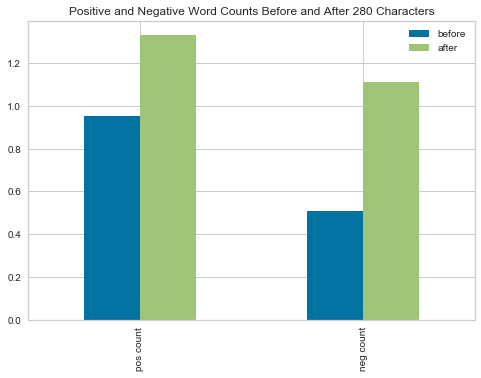

In [203]:
pos_neg_before = df_before.apply(axis = 0, func = np.mean)[[-2,-1]]
pos_neg_after = df_after.apply(axis = 0, func = np.mean)[[-2,-1]]
pos_neg = pd.DataFrame(list(zip(pos_neg_before, pos_neg_after)), 
                       columns = ["before", "after"],
                       index = ["pos count", "neg count"])
pos_neg.plot.bar(title = "Positive and Negative Word Counts Before and After 280 Characters")
plt.savefig('pos_neg.png', dpi=1200, bbox_inches = "tight")

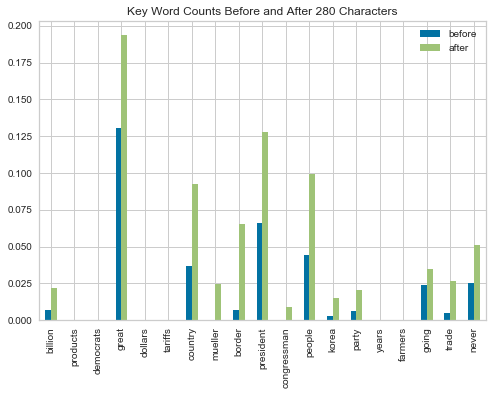

In [204]:
rest_before = df_before.apply(axis = 0, func = np.mean)[1:-2]
rest_after = df_after.apply(axis = 0, func = np.mean)[1:-2]
rest = pd.DataFrame(list(zip(rest_before, rest_after)),
                    columns = ["before", "after"],
                    index = df_before.columns[1:-2])
rest.plot.bar(title = "Key Word Counts Before and After 280 Characters")
plt.savefig('key_word.png', dpi=1200, bbox_inches = "tight")

In [269]:
def regression_models(df_all):
    df_all = df_all.copy()
    X_train, X_test, y_train, y_test =train_test_split(df_all.loc[:, df_all.columns != 'returns'], 
                                                         df_all.returns, test_size=0.2)
    
    scores = {}
    min_max_scaler = MinMaxScaler().fit(X_train)
    xtrain_scaled = min_max_scaler.transform(X_train.values)
    xtest_scaled = min_max_scaler.transform(X_test.values)
    X_train_scaled = pd.DataFrame(xtrain_scaled, columns = X_train.columns, index = X_train.index)
    X_test_scaled = pd.DataFrame(xtest_scaled, columns = X_test.columns, index = X_test.index)
    
#     y_train.plot.hist(bins = 10)
# #     plt.hist(y_train, bins = 10)
#     plt.title("Histogram of Training Set Stock Returns in 5 min")
#     plt.xlabel("Basis Points")
#     plt.savefig('returns_hist.png', dpi=1200, bbox_inches = "tight")
    
    # Linear Regression
    Linear_model = LinearRegression()
    Linear_model.fit(X_train_scaled, y_train)
    
#     visualizer = ResidualsPlot(Linear_model)
#     visualizer.fit(X_train_scaled, y_train)  # Fit the training data to the visualizer
#     visualizer.score(X_test_scaled, y_test)  # Evaluate the model on the test data
#     visualizer.show(outpath='residual_lm.png', dpi=1200, bbox_inches = "tight")
    
#     visualizer1 = PredictionError(Linear_model)
#     visualizer1.fit(X_train_scaled, y_train)  # Fit the training data to the visualizer
#     visualizer1.score(X_test_scaled, y_test)  # Evaluate the model on the test data
#     visualizer1.show()   
    
    # Lasso cv
    CV_lasso = LassoCV(cv = 3, max_iter = 10000)
    CV_lasso.fit(X_train_scaled, y_train)
    
#     visualizer = ResidualsPlot(CV_lasso)
#     visualizer.fit(X_train_scaled, y_train)  # Fit the training data to the visualizer
#     visualizer.score(X_test_scaled, y_test)  # Evaluate the model on the test data
#     visualizer.show(outpath='residual_lasso.png', dpi=1200, bbox_inches = "tight")
    
#     visualizer1 = PredictionError(CV_lasso)
#     visualizer1.fit(X_train_scaled, y_train)  # Fit the training data to the visualizer
#     visualizer1.score(X_test_scaled, y_test)  # Evaluate the model on the test data
#     visualizer1.show() 
    
    # randomforest
    dps = range(1,31)
    mean_score = []

    for dp in dps:
        rf_cv = RandomForestRegressor(n_estimators = 100, max_depth = dp)
        cv_scores = cross_val_score(rf_cv, X_train_scaled, y_train, cv=5, n_jobs = -1)   # -1 means using all processors
        mean_score.append(np.mean(cv_scores))
    d = dps[np.argmax(mean_score)]
    rf = RandomForestRegressor(n_estimators = 100, max_depth = d)
    rf.fit(X_train_scaled,y_train)
    
    visualizer = ResidualsPlot(rf)
    visualizer.fit(X_train_scaled, y_train)  # Fit the training data to the visualizer
    visualizer.score(X_test_scaled, y_test)  # Evaluate the model on the test data
    visualizer.show(outpath='residual_rf.png', dpi=1200, bbox_inches = "tight")
    
#     visualizer1 = PredictionError(rf)
#     visualizer1.fit(X_train_scaled, y_train)  # Fit the training data to the visualizer
#     visualizer1.score(X_test_scaled, y_test)  # Evaluate the model on the test data
#     visualizer1.show() 
    
    models = [Linear_model, CV_lasso, rf]
    names = ['Linear Regression', "Lasso CV", "randomforest"]
    
    for name, model in zip(names, models):
        scores[name] = [mean_squared_error(model.predict(X_train_scaled), y_train), mean_squared_error(model.predict(X_test_scaled), y_test)]
    
    return scores


{'Linear Regression': [41.77042052832157, 44.27574116564023],
 'Lasso CV': [41.84550025459366, 44.30707001712014],
 'randomforest': [41.73819519706857, 44.346764426924096]}

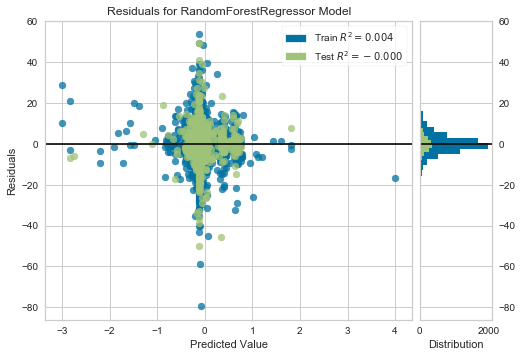

In [270]:
regression_models(merge_data())

In [243]:
def combined(m, times = 5):
    df_all = merge_data(m = m)
    
    import collections
    names = ['Linear Regression', "Lasso CV", "randomforest"]
    scores = collections.defaultdict(list)
    for i in range(times):
        temp = regression_models(df_all)
        for n in names:
            scores[n].append(temp[n][1]) # only test score
            
    for n in names:
        scores[n] = np.mean(scores[n])
    return scores

In [244]:
from tqdm import tqdm
scores = {}
ms = range(1, 60, 3)
for m in tqdm(ms):
    scores[m] = combined(m) 



  0%|          | 0/20 [00:00<?, ?it/s]

  5%|▌         | 1/20 [00:04<01:18,  4.15s/it]

 10%|█         | 2/20 [00:08<01:13,  4.08s/it]

 15%|█▌        | 3/20 [00:12<01:09,  4.08s/it]

 20%|██        | 4/20 [00:16<01:04,  4.03s/it]

 25%|██▌       | 5/20 [00:20<01:00,  4.01s/it]

 30%|███       | 6/20 [00:23<00:55,  3.97s/it]

 35%|███▌      | 7/20 [00:27<00:51,  3.97s/it]

 40%|████      | 8/20 [00:31<00:47,  3.94s/it]

 45%|████▌     | 9/20 [00:35<00:43,  3.96s/it]

 50%|█████     | 10/20 [00:39<00:39,  3.95s/it]

 55%|█████▌    | 11/20 [00:43<00:35,  3.95s/it]

 60%|██████    | 12/20 [00:47<00:31,  3.95s/it]

 65%|██████▌   | 13/20 [00:51<00:27,  3.96s/it]

 70%|███████   | 14/20 [00:55<00:23,  3.93s/it]

 75%|███████▌  | 15/20 [00:59<00:19,  3.92s/it]

 80%|████████  | 16/20 [01:03<00:15,  3.94s/it]

 85%|████████▌ | 17/20 [01:07<00:11,  3.92s/it]

 90%|█████████ | 18/20 [01:11<00:07,  3.93s/it]

 95%|█████████▌| 19/20 [01:14<00:03,  3.90s/it]

100%|██████████| 20/20 [01:18<00:00,

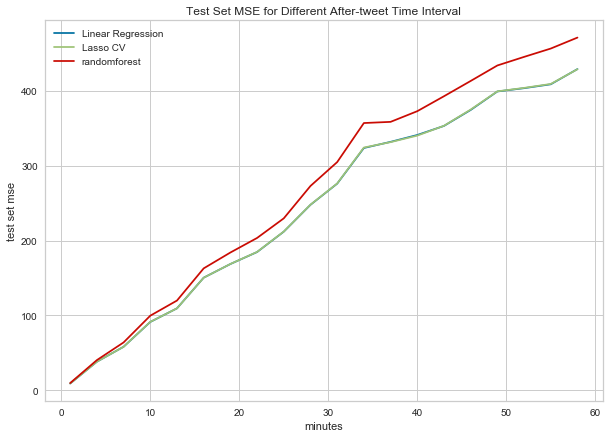

In [245]:
fig, ax = plt.subplots(1,1,figsize = (10,7))
names = ['Linear Regression', "Lasso CV", "randomforest"]
for n in names:
    test_scores = [score[n] for score in scores.values()]
    ax.plot(ms, test_scores, label = n)
    ax.set_xlabel('minutes')
    ax.set_ylabel('test set mse')
    ax.set_title('Test Set MSE for Different After-tweet Time Interval')
ax.legend()

In [246]:
fig.savefig('test_set_mse.png', dpi=1200)